# Create ICESat-2 GDF prior to masking
Copied code from Plot_ATL08 to streamline without deleting anything

In [ ]:
#!pip install earthpy

In [3]:
# Import necessary packages
import os
import rasterio
from rasterio.enums import Resampling
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
import numpy.ma as ma
import pandas as pd
import seaborn as sns
from rasterstats import zonal_stats
import statistics
import scipy.stats as stats
# Use geopandas for vector data and rasterio for raster data
import geopandas as gpd
import rasterio as rio
import rioxarray as riox
# Plotting extent is used to plot raster & vector data together
from rasterio.plot import plotting_extent
from rasterio import features

import earthpy as et
import earthpy.plot as ep

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="white")

%matplotlib inline

In [4]:
#set working directory?
os.chdir(os.path.join(et.io.HOME, 
                      'ICESat-2_Snowdepth'))

In [5]:
dem_path = os.path.join("data",
                       "mcc_dem_3p0m_agg_TUOtrimmed_MANUAL.tif")
dem_9m_path = os.path.join("data",
                       "mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_9m.tif")

In [6]:
ATL08_path = os.path.join("data/ATL08_simplified_snowon/")

In [7]:
filetype = '*.csv'

files = [f for f in os.listdir(ATL08_path) if f.endswith(filetype[1:])]

In [15]:
winter_2020_tracks = glob.glob(ATL08_path + "/*.csv")
winter_2020_tracks

['data/ATL08_simplified_snowon/ATL08_20200205_gt1r.csv',
 'data/ATL08_simplified_snowon/ATL08_20191211_gt1r.csv',
 'data/ATL08_simplified_snowon/ATL08_20200205_gt3r.csv',
 'data/ATL08_simplified_snowon/ATL08_20191112_gt1r.csv',
 'data/ATL08_simplified_snowon/ATL08_20191209_gt3r.csv',
 'data/ATL08_simplified_snowon/ATL08_20200107_gt1l.csv',
 'data/ATL08_simplified_snowon/ATL08_20191112_gt1l.csv',
 'data/ATL08_simplified_snowon/ATL08_20200211_gt3r.csv',
 'data/ATL08_simplified_snowon/ATL08_20200608_gt1r.csv',
 'data/ATL08_simplified_snowon/ATL08_20200309_gt2r.csv',
 'data/ATL08_simplified_snowon/ATL08_20200310_gt1r.csv',
 'data/ATL08_simplified_snowon/ATL08_20191209_gt2r.csv',
 'data/ATL08_simplified_snowon/ATL08_20200310_gt1l.csv',
 'data/ATL08_simplified_snowon/ATL08_20200412_gt2l.csv',
 'data/ATL08_simplified_snowon/ATL08_20200407_gt3r.csv',
 'data/ATL08_simplified_snowon/ATL08_20200309_gt3l.csv',
 'data/ATL08_simplified_snowon/ATL08_20200205_gt3l.csv',
 'data/ATL08_simplified_snowon/

In [9]:
track_names = []
for file in files:
    track_names.append(f'gdf{file[20:22]}_{file[6:10]}-{file[10:12]}-{file[12:14]}')

In [10]:
def open_atl08(data_files):
    
    atlas_df = pd.concat((pd.read_csv(f) for f in data_files), keys=track_names)
    atlas_df = atlas_df.reset_index(level=1, drop=True).rename_axis('Track').reset_index()
    atlas_gdf = gpd.GeoDataFrame(atlas_df, crs='epsg:32611', geometry=gpd.points_from_xy(atlas_df.x, atlas_df.y))
    return atlas_gdf

In [16]:
winter_2020_gdf = open_atl08(winter_2020_tracks)
winter_2020_gdf['date'] = winter_2020_gdf['Track']
winter_2020_gdf['date'] = winter_2020_gdf['date'].map(lambda x: x.split('_')[1])
winter_2020_gdf.head()

,Track,Unnamed: 0,h_te_mean,h_te_median,h_te_min,h_te_max,latitude,longitude,h_te_mode,h_te_skew,n_te_photons,segment_snowcover,terrain_slope,h_te_uncertainty,dem_h,x,y,geometry,date
0,gdfcs_2020-02-05,0,1986.278687,1986.257080,1985.621460,1986.947266,38.218727,-119.286774,1986.000000,0.122473,103.0,2.0,-0.009950,19.284258,1989.658081,299812.579385,4.232556e+06,POINT (299812.579 4232555.953),2020-02-05
1,gdfcs_2020-02-05,1,1984.924561,1984.889160,1984.154541,1986.050049,38.217827,-119.286880,1984.700073,0.815575,181.0,2.0,-0.011663,10.966432,1988.901611,299800.759407,4.232456e+06,POINT (299800.759 4232456.275),2020-02-05
2,gdfcs_2020-02-05,2,1983.748413,1983.722778,1982.881470,1984.601440,38.216930,-119.286987,1983.900024,0.059822,221.0,2.0,-0.013248,8.976236,1987.914551,299788.949707,4.232357e+06,POINT (299788.950 4232357.020),2020-02-05
3,gdfcs_2020-02-05,3,1982.492065,1982.459473,1981.510376,1983.545898,38.216030,-119.287094,1982.400024,0.158004,331.0,2.0,-0.012579,5.989406,1986.772461,299777.129366,4.232257e+06,POINT (299777.129 4232257.342),2020-02-05
4,gdfcs_2020-02-05,4,1981.266846,1981.326538,1980.194214,1982.247314,38.215134,-119.287209,1981.500000,-0.261654,304.0,2.0,-0.013095,6.517324,1985.563354,299764.651298,4.232158e+06,POINT (299764.651 4232158.104),2020-02-05


In [17]:
winter_2020_gdf.crs

<Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 120°W to 114°W - by country
- bounds: (-120.0, 0.0, -114.0, 84.0)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

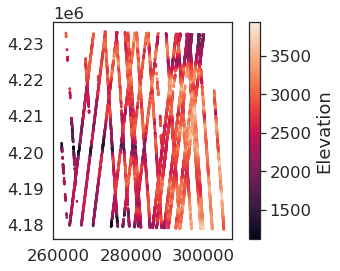

In [18]:
winter_2020_gdf.plot(column='h_te_median', s=2, legend=True, legend_kwds={'label': "Elevation", 'orientation': "vertical"});

In [19]:
dem_path = os.path.join("data",
                       "mcc_dem_3p0m_agg_TUOtrimmed_MANUAL.tif")
dem_9m_path = os.path.join("data",
                       "mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_9m.tif")

In [ ]:
# Proceess and Open Snow-Off Data
# Open the file using a context manager ("with rio.open" statement)

with rio.open(dem_9m_path) as dem_9m:
    dem_9m_arr = dem_9m.read(1)
    dem_9m_meta = dem_9m.profile
    dem_9m_plot_ext = plotting_extent(dem_9m)
    print(dem_9m.crs)

#Clean raster by removing zero values
dem_9m_arr[dem_9m_arr == (-9999.)] = np.nan
dem_9m_arr[dem_9m_arr == (0.)] = np.nan

print(dem_9m_plot_ext)
xmin_9m,ymin_9m,xmax_9m,ymax_9m = dem_9m.bounds